In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
#!pip install holidays
#!pip install xgboost

     --------------------------------------- 70.9/70.9 MB 10.9 MB/s eta 0:00:00


In [35]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [4]:
# import datasets
df=pd.read_csv("C:/Users/15329/OneDrive/桌面/kaggle ipynb/coursesales/train.csv")

In [5]:
df.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [7]:
duplicates = df.duplicated()
num_duplicates = df.duplicated().sum()
print(num_duplicates)

0


In [8]:
df.isnull()
num_null = df.duplicated().sum()
print(num_null)

0


There is no duplicated or null occation in dataset.

In [22]:
# data type convert
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# Create holiday calendars for specific countries
holidays_arg = holidays.Argentina(years=range(2017,2022))
holidays_can = holidays.Canada(years=range(2017,2022))
holidays_est = holidays.Estonia(years=range(2017,2022))
holidays_jap = holidays.Japan(years=range(2017,2022))
holidays_spa = holidays.Spain(years=range(2017,2022))

# Combine all holidays into one set
all_holidays = set()
all_holidays = all_holidays.union(holidays_arg, holidays_can, holidays_est, holidays_jap, holidays_spa)

df['is_holiday'] = df['date'].isin(all_holidays)
df = df.drop('date', axis=1)


## EDA exploratory

1 num sold by date

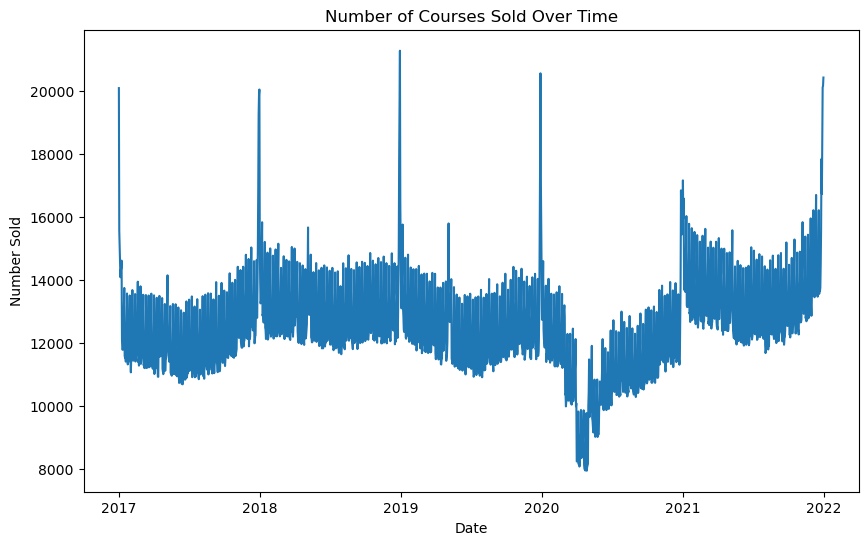

In [10]:
df_grouped = df.groupby('date')['num_sold'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.plot(df_grouped['date'], df_grouped['num_sold'])
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Number of Courses Sold Over Time')
plt.show()

From the picture we can find out that the number sold has a periodic trend and seems like appeared in each year's end and beginning.

2 num sold by country and date

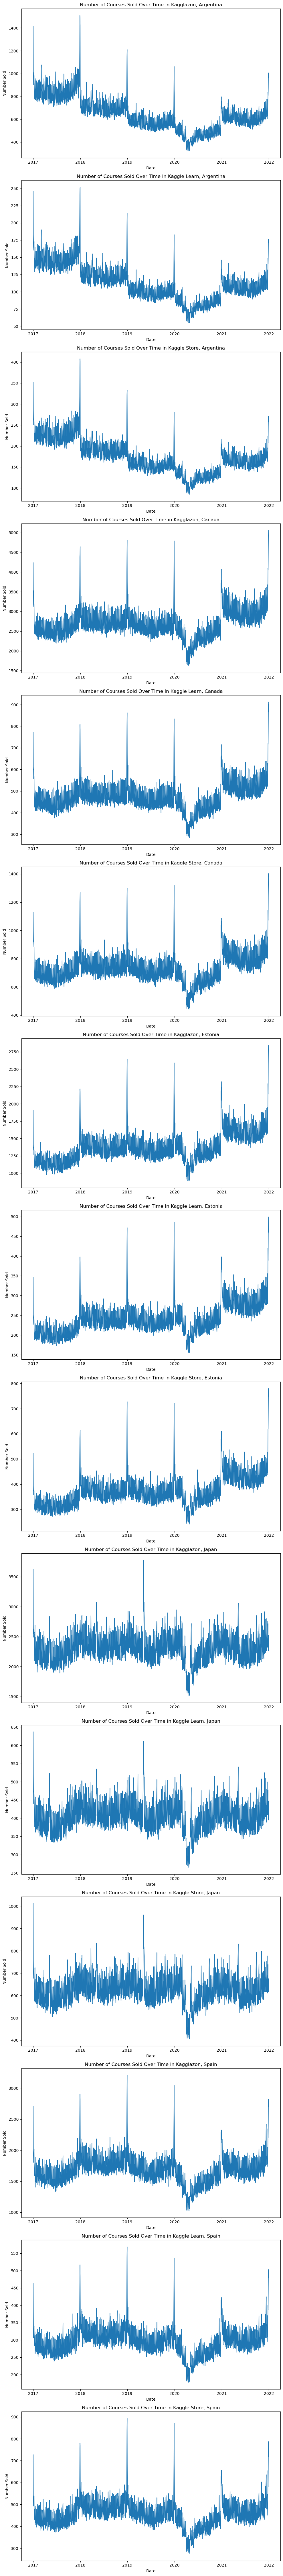

In [11]:
# Group the data by date, country, store, and sum the 'num_sold'
df_grouped = df.groupby(['date', 'country', 'store'])['num_sold'].sum().reset_index()

# Get the unique combinations of country and store
country_store_combinations = df_grouped[['country', 'store']].drop_duplicates()

# Create a plot for each combination
fig, axs = plt.subplots(len(country_store_combinations), 1, figsize=(10, 6*len(country_store_combinations)))

for ax, (index, row) in zip(axs, country_store_combinations.iterrows()):
    country = row['country']
    store = row['store']
    data_to_plot = df_grouped[(df_grouped['country'] == country) & (df_grouped['store'] == store)]
    
    ax.plot(data_to_plot['date'], data_to_plot['num_sold'])
    ax.set_title(f'Number of Courses Sold Over Time in {store}, {country}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number Sold')

plt.tight_layout()
plt.show()

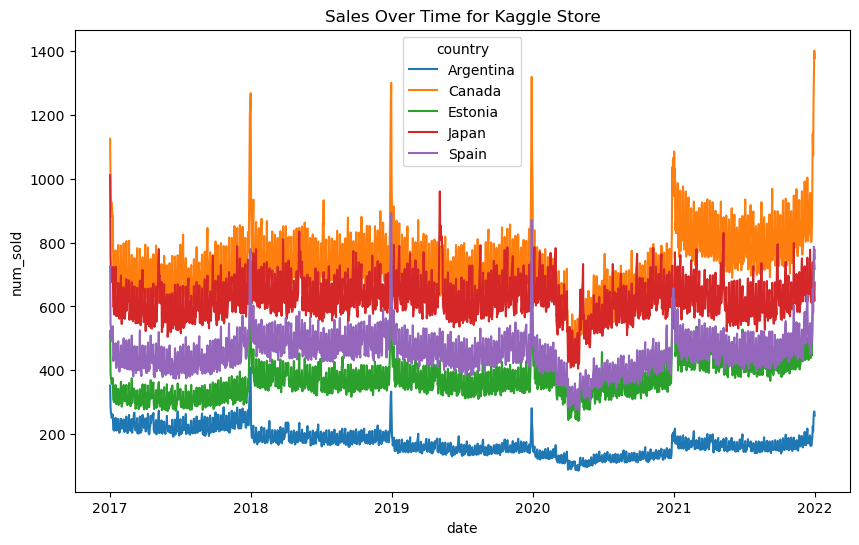

In [12]:
# Filter data for a specific store
data_to_plot = df_grouped[df_grouped['store'] == store]

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='num_sold', hue='country', data=data_to_plot)

plt.title('Sales Over Time for {}'.format(store))
plt.show()

3 num sold by country

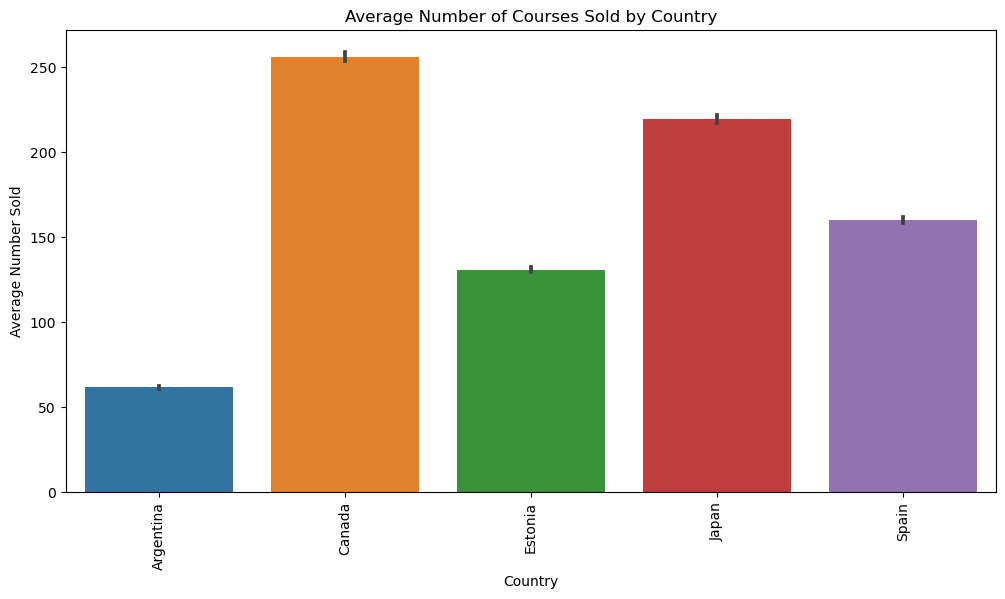

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='num_sold', data=df)
plt.title('Average Number of Courses Sold by Country')
plt.xlabel('Country')
plt.ylabel('Average Number Sold')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()


In [56]:
def smape(y_test, y_pred):
    denominator = (np.abs(y_test) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_test - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)


In [40]:
df_xgb.head()

,id,num_sold,year,month,day,day_of_week,is_weekend,is_holiday,country_Argentina,country_Canada,...,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,0,63,2017,1,1,6,True,True,1,0,...,0,0,0,1,0,1,0,0,0,0
1,1,66,2017,1,1,6,True,True,1,0,...,0,0,0,1,0,0,1,0,0,0
2,2,9,2017,1,1,6,True,True,1,0,...,0,0,0,1,0,0,0,1,0,0
3,3,59,2017,1,1,6,True,True,1,0,...,0,0,0,1,0,0,0,0,1,0
4,4,49,2017,1,1,6,True,True,1,0,...,0,0,0,1,0,0,0,0,0,1


In [57]:
# get dummys of the categorical columns   
df_xgb = pd.get_dummies(df, columns=['country', 'store', 'product'])
# train the model
target = df_xgb['num_sold']
train_df =df_xgb.drop('num_sold', axis=1)
# Select features and target variable

X = df_xgb.drop(['id', 'num_sold'], axis=1) # Drop 'id' and 'num_sold' columns
y = df_xgb['num_sold'] # The target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the XGBRegressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the model to the training data
xg_reg.fit(X_train,y_train)

# Make predictions
y_pred = xg_reg.predict(X_test)

# Compute the RMSE
smape_value = smape(y_test,y_pred)
print("smape: %f" % (smape_value))

smape: 0.502210


In [60]:
X_test.head()

,year,month,day,day_of_week,is_weekend,is_holiday,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
135486,2021,12,12,6,True,False,0,0,1,0,0,0,0,1,0,1,0,0,0
112235,2021,2,5,4,False,False,0,0,1,0,0,0,0,1,1,0,0,0,0
73585,2019,9,9,0,False,False,1,0,0,0,0,1,0,0,1,0,0,0,0
132039,2021,10,27,2,False,False,0,0,1,0,0,0,0,1,0,0,0,0,1
7090,2017,4,5,2,False,False,0,0,1,0,0,1,0,0,1,0,0,0,0


In [61]:
# First, make sure that test_df has the same features as your training data
test_df=pd.read_csv('C:/Users/15329/OneDrive/桌面/kaggle ipynb/coursesales/test.csv')
# Convert the 'date' column to datetime format
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['is_weekend'] = test_df['day_of_week'].isin([5, 6])
test_df['is_holiday'] = test_df['date'].isin(all_holidays)
# Drop the 'date' column
test_df = test_df.drop(columns='date')
test_df = pd.get_dummies(test_df, columns=['country', 'store', 'product'])

# Remember to drop 'id' column before predicting
test_features = test_df.drop(['id'], axis=1)

# Generate predictions
test_predictions = xg_reg.predict(test_features)

# Create a dataframe for your submission
submission_df = pd.DataFrame()

# Add 'id' and 'num_sold' (predictions) to the dataframe
submission_df['id'] = test_df['id']
submission_df['num_sold'] = test_predictions

# Save the dataframe to a csv file
submission_df.to_csv('submission.csv', index=False)